# Generate barcode-to-intron dictionary from nanopore reads

In [1]:
from datetime import date
print('created 2024-04-24')
print("last updated", date.today())

created 2024-04-24
last updated 2024-05-14


In [2]:
# imports

import sys
import time
import pickle
import random
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

import warnings
warnings.filterwarnings(action='once')

# aesthetics
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 151

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

# path to i/o:
IME_path = '/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/'
RIL2_path = IME_path+'RIL2/'
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'

1. download data from BMC and compress as **all_nanopore_reads.fastq.gz** (17.9M reads)
2. run script **0_align_nanopore_reads_to_RIL.sh**: 
    - minimap2 maps these reads to plasmid backbone “genome” **RIL_genome_ORI_start.fa** and generates **RIL_ORI_alignment.sam**

```bash
./minimap2/minimap2 -ax map-ont /nobackup1/ejkk/Cluster/IME/RIL2/RIL_genome_ORI_start.fa /nobackup1/ejkk/Cluster/IME/RIL2/all_nanopore_reads.fastq.gz > /nobackup1/ejkk/Cluster/IME/RIL2/RIL_ORI_alignment.sam
```

2. run script **2_sam_to_sorted_indexed_bam.sh** to generate **RIL_ORI_alignment.sorted.bam** and **RIL_ORI_alignment.sorted.bam.bai.** 
    - note the use of calmd command since i need to generate MD tags to use in pysam later.

```bash
module load engaging/samtools/1.3.1
echo "converting sam -> bam..."
#samtools view -S -b $1.sam > $1.bam
samtools calmd -u /nobackup1/ejkk/Cluster/IME/RIL2/RIL_ORI_alignment.sam /nobackup1/ejkk/Cluster/IME/RIL2/RIL_genome_ORI_start.fa > /orcd/nese/cburge/001/ejkk/RIL2/RIL_ORI_alignment_2.bam
echo "sorting bam..."
samtools sort /orcd/nese/cburge/001/ejkk/RIL2/RIL_ORI_alignment_2.bam -o /orcd/nese/cburge/001/ejkk/RIL2/RIL_ORI_alignment_2.sorted.bam
echo "indexing bam..."
samtools index /orcd/nese/cburge/001/ejkk/RIL2/RIL_ORI_alignment_2.sorted.bam
```

3. run script **3b_get_nanopore_reads_bcs_ints.py** (takes ~11 hours). logic of this script is, briefly: 
    1. for each read that maps contiguously from dTomato barcode through GFP barcode, get the read id, the read length, the dTom barcode sequence, the GFP barcode sequence, the levenshtein edit distance between them, and the intron sequence
    2. store all of this info in **raw_barcode_intron_table.csv** (11.6M sequences)
    3. also take note of reads that pass 4 filters:
        1. length <8900nt (to exclude concatemers)
        2. GFP and dTom barcodes edit distance ≤3
        3. mapped intron region ≥155nt
        4. no missing bases in GFP barcode
    4. save this subset in **filtered_introns.fa** (barcodes and introns only)

### stats about read usage:
- total alignments considered: 13347863
- alignments mapping contiguously through barcodes + intron: 11648921
    - (20.9% of reads fail total read length <8900 filter (suspected concatemers))
    - (17.5% of reads fail edit distance <=3 between GFP and dTom barcodes filter)
    - (22.4% of reads fail mapped intron random region =>155nt filter)
    - (9.5% of reads fail no N or - in GFP barcode filter)
    - (note that many reads fail multiple filters)
- alignments passing filters: 5935092
- this yields **5.9M** reads, 96.5% singletons
    - ultimately I use 50.9% of possible reads based on these combined filters

4. run script **4_usearch_cluster_introns_w_diff_thresholds.sh**
    1. main command is below, with XXX = 0.4, 0.5, 0.6, 0.7, 0.8 or 0.9
    2. note that for now we are only using introns that passed filters from previous script
    
```bash
usearch -cluster_fast /pool001/ejkk/RIL2/filtered_introns.fa -id XXX -consout /pool001/ejkk/RIL2/f_cons_XXX.fa -msaout /pool001/ejkk/RIL2/MSAs/f_msa_XXX.fa -uc /pool001/ejkk/RIL2/f_clusters_XXX.uc
```

### in this notebook:

4. generate **barcode-to-intron dictionaries** from clusterings. this can be done locally. briefly:
    1. parse concatenated MSAs to get all intron and barcode seqs composing each cluster
    2. parse consensus file to get consensus intron sequence of each cluster
    3. build a table of each cluster number, its intron sequence, the most commonly seen barcode for each cluster, and the read count supporting that mapping (i.e. number of alignments in cluster)
    4. discard clusters with only fewer than 3 reads
    5. discard introns with any Ns in consensus
    6. identify multimapping barcodes and compute all pairwise levenshtein distances between their introns
    7. discard barcodes where the mean pairwise edit distance is >20
    8. if mean pairwise edit distance ≤20, keep the mapping supported by the most alignments and discard others.

5. repeat this procedure for multiple rounds of clustering at different identity thresholds and assess overlap in dictionaries 
    1. for example, clustering with 60% identity and 90% identity yielded final dictionaries of 
    51 315 and 57 514 barcodes, respectively, where the overlap (barcode AND intron 100% identical) was **31 833** or 55-62%.
       
    3. for each clustering threshold, process ALL unspliced reads from all replicates of random intron library RNA-seq to see which dictionary (A) recovers the greatest number of reads after filtering for true barcodes and (B) yields the highest accuracy in intron mapping of unspliced fragment to predicted intron sequence 

6. add flanking constant sequences & spike-in barcodes, then (in separate notebook) identify and remove any mismatching barcodes

# explore multiple sequence alignments of filtered introns clustered with usearch

- clustering introns with different % identity thresholds using USEARCH...
    - 90%: **666.1k** clusters, 77.5% singletons (149.8k nonsingleton clusters)
    - 80%: **128.4k** clusters, 49.5% singletons (64.8k nonsingleton clusters)
    - 70%: **65.3k** clusters, 14.8% singletons (55.6k nonsingleton clusters)
    - 60%: **58.4k** clusters, 6.3% singletons (54.7k nonsingleton clusters)
    - 50%: **57.7k** clusters, 5.3% singletons (54.6k nonsingleton clusters)

In [3]:
def parse_MSA(filepath):
    # Define a dictionary to store the MSA clusters
    msa_clusters = {}

    # Open and read the MSA file
    with open(filepath, 'r') as file:
        current_cluster_number = None
        current_read_lines = []
        current_read_id = None
        current_reads = []

        for line in file:
            line = line.strip()

            # Check if the line designates a new cluster
            if line.startswith("==>"):
                # skip line if it's from merging files in multiple stages
                if 'chunk' in line:
                    continue
                # Store the previous read if it exists
                if current_read_id and current_read_lines:
                    current_reads.append((current_read_id, "".join(current_read_lines)))
                # Store the list of reads for the current cluster if it exists
                if current_cluster_number and current_reads:
                    msa_clusters[current_cluster_number] = current_reads
                # Extract the final number from the cluster name
                current_cluster_number = int(line.split("fa")[1].split(" ")[0])
                # Initialize a list to store reads for the current cluster
                current_reads = []
                current_read_id = None
                current_read_lines = []
                continue

            # Check if the line is the read ID
            if line.startswith(">"):
                # if it exists, store the previous read
                if current_read_id and current_read_lines:
                    current_reads.append((current_read_id, "".join(current_read_lines)))
                # then proceed to current read
                current_read_id = line[1:]  # Remove the '>'
                current_read_lines = []
                continue

            # if it's not a new cluster or a read id, it's a read!
            current_read_lines.append(line)       

        # Store the list of reads for the last cluster
        current_reads.append((current_read_id, "".join(current_read_lines)))
        msa_clusters[current_cluster_number] = current_reads
    return msa_clusters

In [4]:
id_thresholds = ['05', '06', '07', '08', '09']
idts = id_thresholds[::-1]

msa_clusters = {}

for threshold in id_thresholds:
    with open(outpath+'data/MSAs/id'+threshold+'msas.pkl', 'rb') as f:
        msa_clusters[threshold] = pickle.load(f)

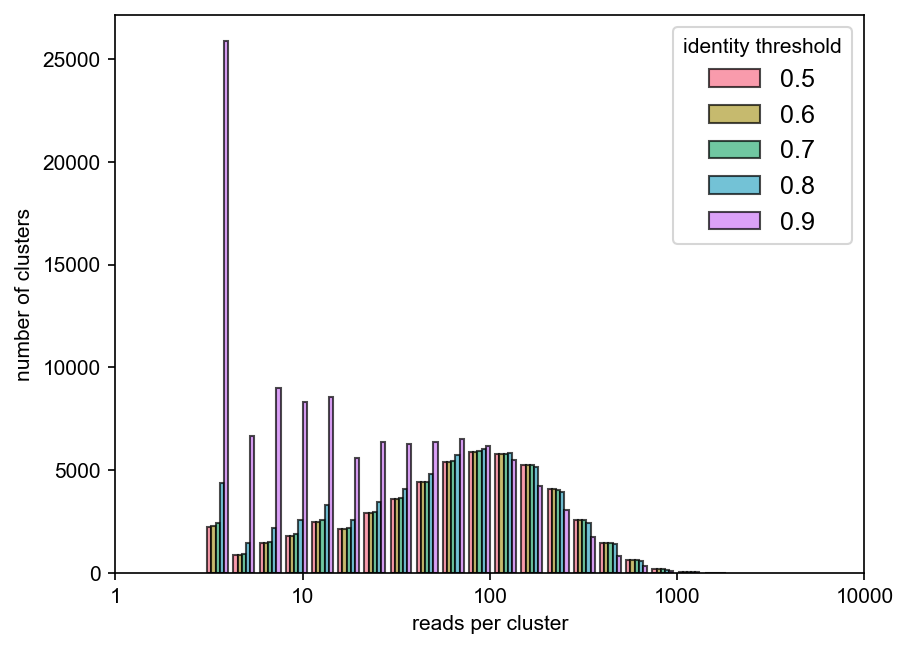

In [5]:
# plot reads per cluster, excluding singletons (or clusters with fewer than 3 reads)
plt.hist([[np.log10(len(x)) for x in msa_clusters[threshold].values() if len(x)>2] for threshold in id_thresholds], 
         bins=20, 
         edgecolor='black', alpha=0.7, label=['0.'+ t.split('0')[1] for t in id_thresholds])

plt.ylabel('number of clusters')
plt.xlabel('reads per cluster')
plt.xticks([0,1,2,3,4],['1','10','100','1000','10000'])
plt.legend(title='identity threshold', fontsize=12)
plt.show()

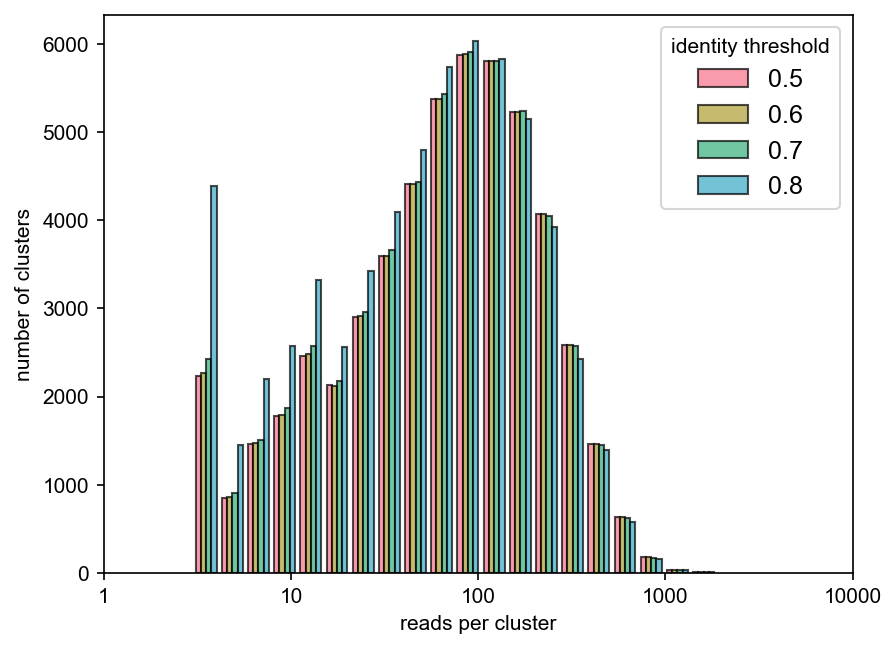

In [12]:
# exclude 0.9

plt.hist([[np.log10(len(x)) for x in msa_clusters[threshold].values() if len(x)>2] for threshold in id_thresholds[:-1]], 
         bins=20, 
         edgecolor='black', alpha=0.7, label=['0.'+ t.split('0')[1] for t in id_thresholds[:-1]])

plt.ylabel('number of clusters')
plt.xlabel('reads per cluster')
plt.xticks([0,1,2,3,4],['1','10','100','1000','10000'])
plt.legend(title='identity threshold', fontsize=12)
plt.show()

# use cluster consensus sequences to construct provisional int-bc maps

In [7]:
# write function to read in cluster consensus sequences and associate each cluster number 
# (convert to int!) with its uppercase consensus intron seq. as dataframe

def parse_cons(fasta_file):
    with open(fasta_file, "r") as file:
        lines = [line.strip() for line in file]

    # Initialize variables
    cluster_numbers, sequences = [], []
    current_cluster_number, current_sequence = None, ""

    # Process lines
    for line in lines:
        if line.startswith(">"):
            if current_cluster_number is not None:
                cluster_numbers.append(current_cluster_number)
                sequences.append(current_sequence.upper())
            current_cluster_number, current_sequence = int(line[8:]), ""
        else:
            current_sequence += line

    # Process the last sequence in the file
    if current_cluster_number is not None:
        cluster_numbers.append(current_cluster_number)
        sequences.append(current_sequence.upper())

    # Create a DataFrame
    df = pd.DataFrame({"intron": sequences}, index=cluster_numbers)
    df = df.drop(0)
    return df

In [8]:
consensus_dfs = {}
for threshold in ['05', '06', '07', '08', '09']:
    consensus_dfs[threshold] = parse_cons(outpath+"data/cons/f_cons_"+threshold+".fa")

In [9]:
# get most frequent barcode seq for each cluster using Counter
# also get # of reads supporting each bc-int assignment

def add_barcodes_from_MSA(MSA, cons_df):
    top_bcs = []
    read_counts = []
    df = cons_df.copy()

    for i in cons_df.index:
        barcodes = [x[0] for x in MSA[i]]
        read_count = len(MSA[i])
        counter = Counter(barcodes)
        top_bcs.append(counter.most_common(1)[0][0])
        read_counts.append(read_count)

    df['barcode'] = top_bcs
    df['read_count'] = read_counts
    
    # drop singletons
    df = df[df['read_count']>2]
    return df

In [13]:
# demonstrate that the most common barcode is likely the only valid barcode
# the 2nd most common barcode is usually represented in < 1 in 20 reads
# and almost always <2nt (i.e. sequencing error) away from the most common barcode

from Levenshtein import distance as lev

def add_barcodes_from_MSA_with_printout(MSA, cons_df):
    df = cons_df.copy()

    for i in cons_df.index:
        barcodes = [x[0] for x in MSA[i]]
        counter = Counter(barcodes)
        
        top2 = counter.most_common(2)
        if len(top2) > 1:
            if top2[0][1] > 9:
                if top2[1][1] > 1:
                    top2ratio = top2[0][1]/top2[1][1]
                    top2dist = lev(top2[0][0],top2[1][0])
                    if top2ratio < 100:
                        if top2dist > 4:
                            print(f'{top2}   \t ratio: {top2ratio:.0f} \t dist: {top2dist}')

for i in idts[:-1]:    # skip 05 bc there are too many
    print(i)
    add_barcodes_from_MSA_with_printout(msa_clusters[i],consensus_dfs[i])
    print()

09
[('TCACTCATACTTTCCTCT', 37), ('ACTCATACTTTCCTCGAC', 2)]   	 ratio: 18 	 dist: 5
[('TATCATCTTGAACTTCGA', 1055), ('AAAAATACCCCCTTATCT', 55)]   	 ratio: 19 	 dist: 13
[('TACGTCACCTAAGGCGAA', 126), ('CATCAACCATCATCTTAT', 2)]   	 ratio: 63 	 dist: 11
[('TCATACCCCCCCTCACAC', 20), ('AATCATGCCCCCTCACAC', 3)]   	 ratio: 7 	 dist: 5

08
[('TCACTCATACTTTCCTCT', 38), ('ACTCATACTTTCCTCGAC', 2)]   	 ratio: 19 	 dist: 5
[('TATCATCTTGAACTTCGA', 1129), ('AAAAATACCCCCTTATCT', 55)]   	 ratio: 21 	 dist: 13
[('TACGTCACCTAAGGCGAA', 130), ('CATCAACCATCATCTTAT', 4)]   	 ratio: 32 	 dist: 11
[('TCATACCCCCCCTCACAC', 21), ('AATCATGCCCCCTCACAC', 3)]   	 ratio: 7 	 dist: 5

07
[('TCACTCATACTTTCCTCT', 39), ('ACTCATACTTTCCTCGAC', 2)]   	 ratio: 20 	 dist: 5
[('TATCATCTTGAACTTCGA', 1131), ('AAAAATACCCCCTTATCT', 55)]   	 ratio: 21 	 dist: 13
[('TACGTCACCTAAGGCGAA', 130), ('CATCAACCATCATCTTAT', 4)]   	 ratio: 32 	 dist: 11
[('TCATACCCCCCCTCACAC', 21), ('AATCATGCCCCCTCACAC', 3)]   	 ratio: 7 	 dist: 5

06
[('TCACTCA

In [14]:
# save this to make a plot later

def save_barcodes_from_MSA(MSA, cons_df):
    results = []
    df = cons_df.copy()

    for i in cons_df.index:
        barcodes = [x[0] for x in MSA[i]]
        counter = Counter(barcodes)
        
        top2 = counter.most_common(2)
        if len(top2) > 1:
            if top2[0][1] > 9:
                if top2[1][1] > 1:
                    top2dist = lev(top2[0][0],top2[1][0])
                    results.append(top2dist)
    return results

bc_dists_06 = save_barcodes_from_MSA(msa_clusters['06'],consensus_dfs['06'])

with open(outpath+'pkls/bc_dists_06_min3readclusters.pkl', 'wb') as f:
    pickle.dump(bc_dists_06, f)

In [15]:
# merge dataframes to get barcodes, ints, reads supporting 
raw_b2i_dfs_with_Ns = {}
raw_b2i_dfs = {}
for threshold in ['05', '06', '07', '08', '09']:
    raw_b2i_dfs_with_Ns[threshold] = add_barcodes_from_MSA(msa_clusters[threshold],
                                                  consensus_dfs[threshold])

# drop all introns with Ns in consensus sequence
for x in id_thresholds:
    raw_b2i_dfs[x] = raw_b2i_dfs_with_Ns[x][~raw_b2i_dfs_with_Ns[x]['intron'].str.contains("N")]
    print(f'{x}: {len(raw_b2i_dfs_with_Ns[x])} -> {len(raw_b2i_dfs[x])}')

05: 53096 -> 49662
06: 53176 -> 49782
07: 53799 -> 50053
08: 60061 -> 52328
09: 111351 -> 75564


In [16]:
# identify barcodes that map to multiple clusters
def get_multimappers(df):
    counter = Counter(df.barcode)
    sus = [element for element, count in counter.items() if count > 1]
    return df[df['barcode'].isin(sus)]

# for suspicious barcodes, get pairwise levenshtein distances between their introns
def get_clusters_pairwise_lev(df):
    sus_scores = {}
    for suspect in list(set(df['barcode'])):
        sus_introns = df.intron[df['barcode']==suspect]
        int_pairs = [(x, y) for i, x in enumerate(sus_introns) for j, y in enumerate(sus_introns) if i < j]
        sus_scores[suspect] = [lev(p[0],p[1]) for p in int_pairs]
        return sus_scores
        
# will drop multimapping barcodes from table if mean inter-intron edit distance is >20
# otherwise will retain assignment supported by the most reads and drop others
def drop_naughty_barcodes(df,sus_scores):
    to_drop = [(x) for x,y in sus_scores.items() if np.mean(y)>20]
    to_fix = [(x) for x,y in sus_scores.items() if np.mean(y)<=20]
    
    b2i_df = df[~df['barcode'].isin(to_drop)]

    for bc in to_fix:
        to_fix_df = b2i_df[b2i_df['barcode']==bc]
        bc_ids = list(to_fix_df.index)
        read_counts = list(b2i_df.read_count[bc_ids])
        del bc_ids[(read_counts.index(max(read_counts)))]
        b2i_df = b2i_df.drop(bc_ids)
    return b2i_df

In [17]:
multimappers = {}
for x in id_thresholds:
    multimappers[x] = get_multimappers(raw_b2i_dfs[x])

pairwise_levs = {}
for x in id_thresholds:
    pairwise_levs[x] = get_clusters_pairwise_lev(multimappers[x])

b2i_dfs = {}
for x in id_thresholds:
    b2i_dfs[x] = drop_naughty_barcodes(raw_b2i_dfs[x], pairwise_levs[x])

b2is = {}
for x in id_thresholds:
    b = b2i_dfs[x]
    b2is[x] = dict(zip(b['barcode'], b['intron']))

In [18]:
# get read counts supporting each cluster as proxy for abundance in library
# for the 0.6 b2i

bc_to_nanopore_rc_06 = {bc:rc for (bc,rc) in zip(b2i_dfs['06']['barcode'],b2i_dfs['06']['read_count'])}

In [19]:
# save these dictionaries

with open(outpath+'pkls/diff_threshold_b2is_min3readclusters.pkl', 'wb') as f:
    pickle.dump(b2is, f)

with open(outpath+'pkls/bc_to_nanopore_rc_06_min3readclusters.pkl', 'wb') as f:
    pickle.dump(bc_to_nanopore_rc_06, f)

# evaluate which b2i gives greatest mapping accuracy to introns detected in unspliced reads

In [20]:
with open(outpath+'pkls/diff_threshold_b2is_min3readclusters.pkl', 'rb') as f:
    b2is = pickle.load(f)

In [21]:
# load and concatenate lists of unspliced reads
with(open(outpath+'data/reads/RIL2_1_unspliced_list_both_reads.pkl','rb')) as f:
    unspliced1 = pickle.load(f)
with(open(outpath+'data/reads/RIL2_1_unspliced_list_both_reads.pkl','rb')) as f:
    unspliced2 = pickle.load(f)

# store as dict and drop iFACS samples
unspliced_rev_read_dict = {b:{s:[] for s in [1,2,3,4,5]} for b,x in unspliced1+unspliced2}
for b,(f,r,i) in unspliced1+unspliced2:
    if i<6:
        unspliced_rev_read_dict[b][i].append(r)

In [22]:
for id in idts:
    print(len(b2is[id]))
print()
print(len(set(b2is['06'].items()).intersection(set(b2is['09'].items()))))

50224
49971
49778
49737
49612

39057


In [23]:
five_SS = 'GTGAGTAGCGGG'

def get_average_b2i_error_rate_from_unspliced_reads(unspliced_read_dict, b2i):

    # get list of barcodes that are in b2i and in unspliced reads
    bcs = list(set(unspliced_read_dict.keys()).intersection(set(b2i.keys())))

    # use a dictionary to store read mismatch info for each barcode in each sample
    sample_mismatch_fractions = {x:{b:{'match':0,'mismatch':0,'mmf':0} for b in bcs} for x in np.arange(1,13)}
    
    #print(f'calculating mismatch info per barcode...')
    
    # calculate mismatch info per barcode per sample
    # by comparing the introns in reads to introns in dict using levenshtein distance
    for barcode in bcs:
        for sample in np.arange(1,6):
            if len(unspliced_read_dict[barcode][sample])>0:
                for read in unspliced_read_dict[barcode][sample]:
                    five_SS_read = read[16:26]
                    if lev(five_SS_read,five_SS) <= 2:    # only look at reads containing canonical 5'SS
                        int_frag = read[28:]
                        bc_int = b2i[barcode]
                        dist = lev(int_frag, bc_int[:len(int_frag)])
                        if dist > 3:
                            sample_mismatch_fractions[sample][barcode]['mismatch']+=1
                        else:
                            sample_mismatch_fractions[sample][barcode]['match']+=1
    
    #print('done')
    #print('removing barcodes w no unspliced reads...')
    
    # remove barcodes that have no unspliced reads
    for b in bcs:
        for x in np.arange(1,6):
            if np.sum([x for x in sample_mismatch_fractions[x][b].values()]) == 0:
                del sample_mismatch_fractions[x][b]
    
    #print('done')
    #print('getting mismatch info per sample...')

    # now get mismatch info per sample
    # by checking which barcodes have more than 10% of their reads mismatched
    match_rates = []
    for x in np.arange(1,6):
        #print(x)
        for b in sample_mismatch_fractions[x]:
            reads = sample_mismatch_fractions[x][b]['match']+sample_mismatch_fractions[x][b]['mismatch']
            mmf = sample_mismatch_fractions[x][b]['mismatch']/(reads)
            sample_mismatch_fractions[x][b]['mmf'] = mmf
        total_bcs = len(sample_mismatch_fractions[x])
        bad_bcs = len([f for f in [sample_mismatch_fractions[x][b]['mmf'] for b in sample_mismatch_fractions[x]] if f>0.1])
        mr = (bad_bcs/total_bcs)*100
        match_rates.append(mr)

    #print('done')
        
    return bcs, match_rates

In [24]:
for k in list(b2is.keys())[::-1]:
    bcs, match_rates = get_average_b2i_error_rate_from_unspliced_reads(unspliced_rev_read_dict, b2is[k])
    print(f'{k} b2i: {len(bcs)} barcodes')
    print(f'average mismatch rate across samples: {np.mean(match_rates):.1f}')
    #print(f'(actual mismatch rates: {match_rates})')
    print(f'average # of useable barcodes: {len(bcs)*(1-(np.mean(match_rates)/100)):.0f}')
    print()

09 b2i: 15239 barcodes
average mismatch rate across samples: 5.3
average # of useable barcodes: 14433

08 b2i: 15186 barcodes
average mismatch rate across samples: 3.0
average # of useable barcodes: 14724

07 b2i: 15115 barcodes
average mismatch rate across samples: 2.8
average # of useable barcodes: 14696

06 b2i: 15109 barcodes
average mismatch rate across samples: 2.7
average # of useable barcodes: 14700

05 b2i: 15096 barcodes
average mismatch rate across samples: 2.7
average # of useable barcodes: 14689



I will proceed with the 0.6 id threshold b2i as my primary dictionary

# how are reads distributed across these introns?

In [25]:
with open(outpath+'pkls/bc_to_nanopore_rc_06_min3readclusters.pkl', 'rb') as f:
    bc_to_nanopore_rc_06 = pickle.load(f)

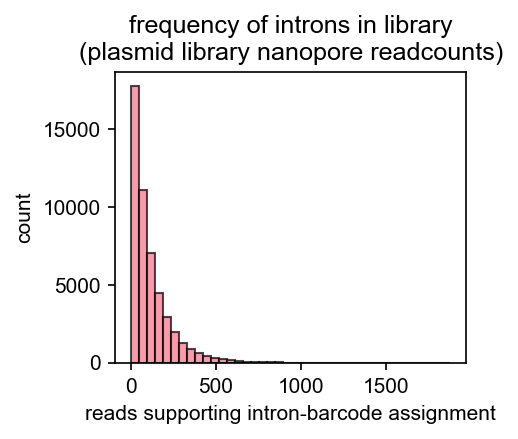

In [26]:
plt.figure(figsize=(3,2.5))
plt.hist([(x) for x in bc_to_nanopore_rc_06.values()], 
         bins=40, 
         edgecolor='black', alpha=0.7)

plt.ylabel('count')
plt.xlabel('reads supporting intron-barcode assignment')
plt.title('frequency of introns in library\n(plasmid library nanopore readcounts)')
plt.show()

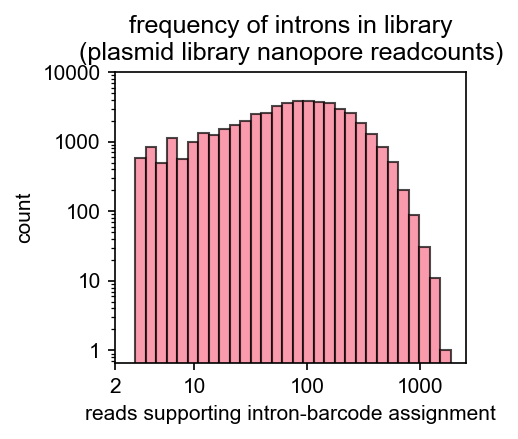

In [28]:
plt.figure(figsize=(3,2.5))
plt.hist([np.log10(x) for x in bc_to_nanopore_rc_06.values()], 
         bins=30, 
         edgecolor='black', alpha=0.7)

plt.ylabel('count')
plt.xlabel('reads supporting intron-barcode assignment')
plt.title('frequency of introns in library\n(plasmid library nanopore readcounts)')
plt.xticks([np.log10(2),1,2,3],['2','10','100','1000'])
plt.yscale('log')
plt.yticks([1,10,100,1000,10000],['1','10','100','1000','10000'])
plt.show()

In [29]:
len(bc_to_nanopore_rc_06)

49737

In [30]:
b2i_rcs = np.array([x for x in bc_to_nanopore_rc_06.values()])

In [31]:
b2i_rcs.mean()

116.30775881134768

In [32]:
np.median(b2i_rcs)

78.0

# take top b2i dictionary and add flanking constant sequences, spike-in barcodes

In [33]:
# take introns clustered using 0.6 id threshold as working b2i

with open(outpath+'pkls/diff_threshold_b2is_min3readclusters.pkl', 'rb') as f:
    b2is = pickle.load(f)
b2i = b2is['06']

In [34]:
five_flank = 'gtgagtagcggg'
three_flank = 'gcctcagacagtggttcaaagtttttttcttccatttcag'
for bc in b2i:
    b2i[bc] = five_flank + b2i[bc] + three_flank

In [35]:
# remove barcodes of compromised intronless spike-ins 
# (these barcodes are also present in library assoc. w random introns)

for cbc in ['TATATTATATCTTCTTTA','CCCCCTCTCATCCCACAA']:
    if cbc in b2i:
        del b2i[cbc]

# otherwise set intronless seq as empty

true_intronless_barcodes = ['ACTATCTAACCAAACACA', 
                           'ACTCCTTCAATCCCATCA',
                           'CATAACTTAATTATTTTA',
                           'TACATTATCTCTTCATAC']

for t in true_intronless_barcodes:
    b2i[t] = ''

# and set UbC barcode to UbC intron

UbC_seq = 'gtgagtagcggg' + ('ctgctgggctggccggggctttcgtggccgccgggccgctcggtgggacggaggcgtgtggagagaccgccaagggctgtagtctgggtccgcgagcaaggttgccctgaactgggggttggggggagcgcagcaaaatggcggctgttcccgagtcttgaatggaagacgcttgtgaggcgggctgtgaggtcgttgaaacaaggtggggggcatggtgggcggcaagaacccaaggtcttgaggccttcgctaatgcgggaaagctcttattcgggtgagatgggctggggcaccatctggggaccctgacgtgaagtttgtcactgactggagaactcggtttgtcgtctgttgcgggggcggcagttatggcggtgccgttgggcagtgcacccgtacctttgggagcgcgcgccctcgtcgtgtcgtgacgtcacccgttctgttggcttataatgcagggtggggccacctgccggtaggtgtgcggtaggcttttctccgtcgcaggacgcagggttcgggcctagggtaggctctcctgaatcgacaggcgccggacctctggtgaggggagggataagtgaggcgtcagtttctctggtcggttttatgtacctatcttcttaagtagctgaagctccggttttgaactatgcgctcggggttggcgagtgtgttttgtgaagttttttaggcaccttttgaaatgtaatcatttgggtc').upper() + 'gcctcagacagtggttcaaagtttttttcttccatttcag'
b2i['ATACCATAACTACCCACT'] = UbC_seq

In [36]:
# save this dictionary

with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters.pkl', 'wb') as f:
    pickle.dump(b2i, f)